# Propuesta de Proyecto: Recomendación de Videojuegos en Amazon
**IIC3633 Sistemas Recomendadores (2025-1)**  
Integrantes: **Geraldine Coli Acevedo**, **Carlos Olguín**, **René Saavedra Vargas**.  

## 1. Introducción

El siguiente cuaderno presenta una propuesta de proyecto para el curso IIC3633 Sistemas Recomendadores. Se realiza un análisis exploratorio de datos sobre un conjunto de datos de ratings de Amazon (enfocado en Videojuegos). El conjunto de datos se obtiene a partir de [Amazon Review Data (2023)](https://amazon-reviews-2023.github.io) de McAuley Lab. En particular se utiliza el conjunto **Video Games (Review, Metadata)** para obtener los ratings de los videojuegos y su información asociada.

Para ejecutar este cuaderno, es necesario descargar los archivos y descomprimirlos en la carpeta `data/`.

## 2. Pasos preliminares

### 2.1. Variables

In [77]:
TEST_SIZE = 0.1
DATASET_SIZE = 0.01
RANDOM_STATE = 42

### 2.2. Instalación de dependencias


In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable


### 2.3. Cargar datos

In [99]:
metadata_path   = os.path.join('newproject', 'meta_Video_Games.jsonl')
video_games_path = os.path.join('newproject', 'Video_Games.jsonl')

metadata_df    = pd.read_json(metadata_path, lines=True)
video_games_df = pd.read_json(video_games_path, lines=True)

print(metadata_df.shape, metadata_df.columns)
print(video_games_df.shape, video_games_df.columns)

KeyboardInterrupt: 

In [50]:
df = video_games_df.sample(frac=DATASET_SIZE, random_state=RANDOM_STATE).reset_index(drop=True)

### 2.4. Preprocesar datos

In [80]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)


In [55]:
def df_stats(interactions_df, metadata_df):
    # ————— Estadísticas de interacciones —————
    n_users = interactions_df['user_id'].nunique()
    n_items = interactions_df['asin'].nunique()
    total_ratings = len(interactions_df)
    avg_rpu = round(total_ratings / n_users, 1) if n_users > 0 else 0.0
    avg_rpi = round(total_ratings / n_items, 1) if n_items > 0 else 0.0
    avg_rating = round(interactions_df['rating'].mean(), 1) if total_ratings > 0 else 0.0
    std_rating = round(interactions_df['rating'].std(), 1) if total_ratings > 1 else 0.0

    if total_ratings > 0:
        max_by_user = int(interactions_df.groupby('user_id').size().max())
        max_by_item = int(interactions_df.groupby('asin').size().max())
    else:
        max_by_user = 0
        max_by_item = 0

    # ————— Estadísticas de descripciones —————
    # Obtener los parent_asin que están en las interacciones
    relevant_asins = interactions_df['asin'].unique()
    filtered_metadata = metadata_df[metadata_df['parent_asin'].isin(relevant_asins)].copy()

    # Normalizar las descripciones
    def normalize_desc(x):
        if isinstance(x, list):
            return ' '.join([str(fragment) for fragment in x if fragment])
        elif isinstance(x, str):
            return x
        else:
            return ''

    desc_series = filtered_metadata['description'].apply(normalize_desc)
    desc_word_counts = desc_series.apply(lambda txt: len(txt.split()) if txt.strip() else 0)

    n_items_with_desc = int((desc_word_counts > 0).sum())
    n_items_without_desc = int((desc_word_counts == 0).sum())

    if n_items_with_desc > 0:
        min_len = int(desc_word_counts[desc_word_counts > 0].min())
        max_len = int(desc_word_counts.max())
        mean_len = round(desc_word_counts[desc_word_counts > 0].mean(), 1)
        std_len = round(desc_word_counts[desc_word_counts > 0].std(), 1)
    else:
        min_len = 0
        max_len = 0
        mean_len = 0.0
        std_len = 0.0

    return {
        # — Estadísticas de interacciones —
        'Número de usuarios'                  : n_users,
        'Número de ítems'                    : n_items,
        'Cantidad total de ratings'          : total_ratings,
        'Promedio de ratings por usuario'     : avg_rpu,
        'Promedio de ratings por ítem'       : avg_rpi,
        'Rating promedio'                    : avg_rating,
        'Desviación estándar del rating'     : std_rating,
        'Máximo de ratings por usuario'      : max_by_user,
        'Máximo de ratings por ítem'         : max_by_item,

        # — Estadísticas de descripciones —
        'Número de ítems sin descripción'    : n_items_without_desc,
        'Número de ítems con descripción'    : n_items_with_desc,
        'Longitud mínima de descripción'     : min_len,
        'Longitud máxima de descripción'     : max_len,
        'Longitud promedio de descripción'   : mean_len,
        'Desviación estándar longitud descr' : std_len,
    }


In [56]:
stats_train = df_stats(train_df, metadata_df)
stats_test = df_stats(test_df, metadata_df)

table = PrettyTable()
table.field_names = ["Estadística", "Train", "Test"]
for key in stats_train.keys():
    table.add_row([key, stats_train[key], stats_test[key]])

print(table)


+------------------------------------+--------+-------+
|            Estadística             | Train  |  Test |
+------------------------------------+--------+-------+
|         Número de usuarios         | 174637 | 45465 |
|          Número de ítems           | 48179  | 21388 |
|     Cantidad total de ratings      | 184984 | 46247 |
|  Promedio de ratings por usuario   |  1.1   |  1.0  |
|    Promedio de ratings por ítem    |  3.8   |  2.2  |
|          Rating promedio           |  4.0   |  4.0  |
|   Desviación estándar del rating   |  1.4   |  1.4  |
|   Máximo de ratings por usuario    |   28   |   7   |
|     Máximo de ratings por ítem     |  786   |  186  |
|  Número de ítems sin descripción   | 10605  |  4237 |
|  Número de ítems con descripción   | 20206  |  8515 |
|   Longitud mínima de descripción   |   1    |   1   |
|   Longitud máxima de descripción   | 15942  |  4260 |
|  Longitud promedio de descripción  | 185.2  | 203.9 |
| Desviación estándar longitud descr | 325.1  | 

Realizamos gráficos para analizar los datos.

#### 2.5. Analisis de datos

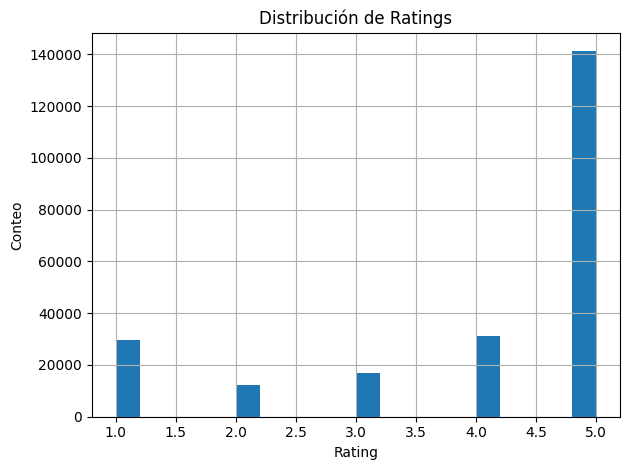

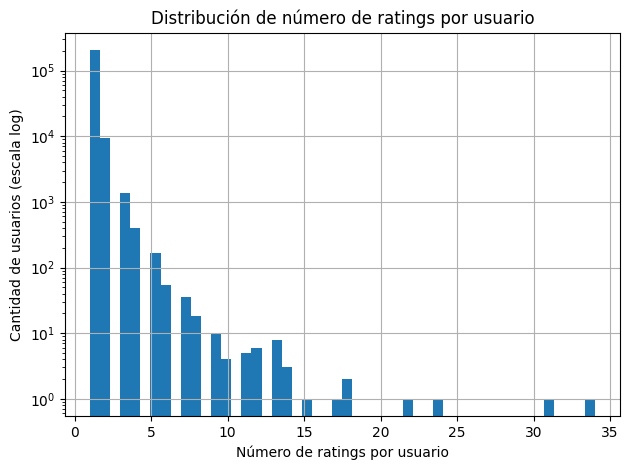

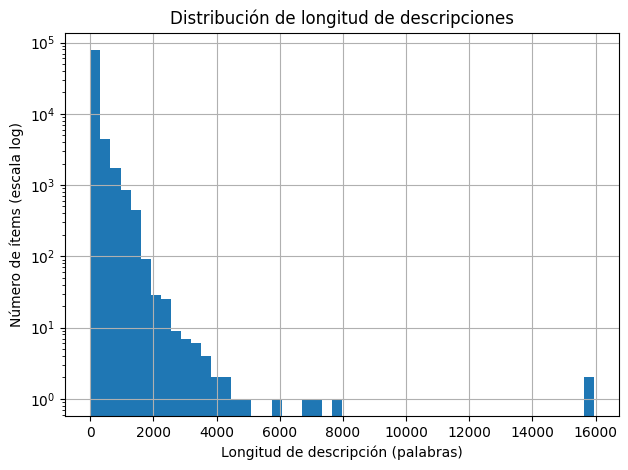

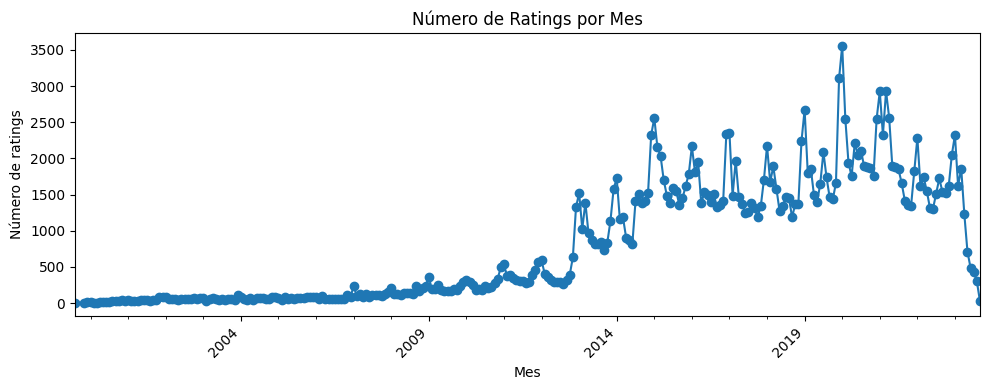

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Histograma de distribución de ratings
plt.figure()
df['rating'].hist(bins=20)
plt.xlabel('Rating')
plt.ylabel('Conteo')
plt.title('Distribución de Ratings')
plt.tight_layout()

# 2. Histograma de número de ratings por usuario (escala logarítmica)
user_counts = df.groupby('user_id').size()
plt.figure()
user_counts.hist(bins=50, log=True)
plt.xlabel('Número de ratings por usuario')
plt.ylabel('Cantidad de usuarios (escala log)')
plt.title('Distribución de número de ratings por usuario')
plt.tight_layout()

# 3. Histograma de longitud de descripciones (solo ítems con descripción)
def normalize_desc(x):
    if isinstance(x, list):
        return ' '.join([str(fragment) for fragment in x if fragment])
    elif isinstance(x, str):
        return x
    else:
        return ''

desc = metadata_df['description'].apply(normalize_desc).fillna('')
desc_lens = desc.apply(lambda t: len(t.split()) if t.strip() else 0)
plt.figure()
desc_lens[desc_lens > 0].hist(bins=50, log=True)
plt.xlabel('Longitud de descripción (palabras)')
plt.ylabel('Número de ítems (escala log)')
plt.title('Distribución de longitud de descripciones')
plt.tight_layout()

# 4. Serie de tiempo: número de ratings por mes
df['year_month'] = df['timestamp'].dt.to_period('M')

monthly_counts = df.groupby('year_month').size().sort_index()
plt.figure(figsize=(10, 4))
monthly_counts.plot(marker='o', linestyle='-')
plt.xlabel('Mes')
plt.ylabel('Número de ratings')
plt.title('Número de Ratings por Mes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()



## 3. Modelos de prueba

#### 3.1. Modelos simples

In [57]:
def asin_to_title(asin: str) -> str:
    """
    Dada un ASIN, devuelve el título del videojuego.
    """
    if asin in metadata_df['parent_asin'].values:
        return metadata_df.loc[metadata_df['parent_asin'] == asin, 'title'].values[0]
    else:
        return "Título no encontrado"
    
def print_recommendations(recommendations: list):
    """
    Imprime las recomendaciones con sus títulos.
    """
    print("Recomendaciones:")
    for asin in recommendations:
        title = asin_to_title(asin)
        print(f"- {title} (ASIN: {asin})")
    

Realizamos pruebas con diferentes modelos simples de referencia. Utilizamos una clase RecomendadorBase que se utiliza para crear los otros recomendadores.

In [58]:
from surprise import Dataset, Reader, KNNBasic, SVD

class RecomendadorBase:
    """
    Clase base para todos los recomendadores.
    Formato a utilizar: userId, itemId, rating
    """
    def fit(self, df: pd.DataFrame):
        raise NotImplementedError

    def recommend(self, user_id, n_items=10):
        raise NotImplementedError

Recomendadores base, Random y Most Popular. Estos recomendadores no utilizan información de los usuarios ni de los ítems, sino que se basan en estrategias simples para generar recomendaciones.

In [92]:
class RecomendadorRandom(RecomendadorBase):
    """
    Recomendador aleatorio.
    """
    import numpy as np
    def fit(self, df: pd.DataFrame):
        self.df = df['asin'].unique().tolist()

    def recommend(self, user_id, n_items=10):
        recs = np.random.choice(self.df, size=n_items, replace=False)
        return recs.tolist()
    
class RecomendadorPopular(RecomendadorBase):
    """
    Recomendador basado en popularidad.
    """
    def fit(self, df: pd.DataFrame):
        train_pos = df[df['rating'] >= 4]

        pop_counts = (
            train_pos
            .groupby('asin')
            .size()
            .reset_index(name='pos_count')
            .sort_values('pos_count', ascending=False)
        )
        
        self.most_popular_list = pop_counts['asin'].tolist()

    def recommend(self, user_id, n_items=10):
        return self.most_popular_list[:n_items]


#### 3.2. Modelo basado en contenido

In [102]:
from scipy.sparse import vstack

def user_profile(user_id):
    # Ítems positivos en train (rating >= 4)
    uid_train_pos = df[
        (df['user_id'] == user_id) & (df['rating'] >= 4)
    ]['asin'].tolist()
    vectors = []
    
    for a in uid_train_pos:
        if a in item_to_idx:
            vectors.append(item_tfidf[item_to_idx[a]])
    if not vectors:
        return None
    return vstack(vectors).mean(axis=0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import vstack
import numpy as np

class RecomendadorContent(RecomendadorBase):
    """
    Recomendador basado en contenido (TF-IDF + cosine).
    """
    def fit(self, df: pd.DataFrame):
        self.df = df

        if 'text_features' not in metadata_df.columns:
            metadata_df['text_features'] = (
                metadata_df['title'].fillna('') + ' ' +
                metadata_df['description'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '') + ' ' +
                metadata_df['main_category'].fillna('')
            )
        
        self.tfidf = TfidfVectorizer(max_features=5000)
        self.item_tfidf = self.tfidf.fit_transform(metadata_df['text_features'])
        
        self.item_to_idx = {asin: idx for idx, asin in enumerate(metadata_df['parent_asin'])}
        self.asin_list = list(metadata_df['parent_asin'])

    def recommend(self, user_id, n_items=10):
        # 1) Obtenemos los ítems que el usuario ha valorado >= 4 en el DF de entrenamiento
        
        user_hist = self.df[(self.df['user_id'] == user_id) & (self.df['rating'] >= 4)]['asin'].tolist()
        
        if not user_hist:
            # Si no hay historial positivo, caemos al recomendador de popularidad (Fallback)
            popular_recommender = RecomendadorPopular()
            popular_recommender.fit(self.df)
            return popular_recommender.recommend(user_id, n_items)

        # 2) Convertir el historial a índices TF-IDF
        idx_list = [self.item_to_idx[asin] for asin in user_hist if asin in self.item_to_idx]
        if not idx_list:
            # Si ninguno de los ASIN del historial está en metadata_df
            popular_recommender = RecomendadorPopular()
            popular_recommender.fit(self.df)
            return popular_recommender.recommend(user_id, n_items)

        # 3) Calcular vector de perfil del usuario (media de sus vectores TF-IDF)
        user_vec = vstack([self.item_tfidf[i] for i in idx_list]).mean(axis=0)
        user_vec = np.asarray(user_vec) # Arregla error en python 3.11

        sims = linear_kernel(user_vec, self.item_tfidf).flatten()  # ya es np.ndarray

        # 5) Ordenar de mayor a menor similitud y filtrar los ya vistos
        top_indices = np.argsort(sims)[::-1]
        recs = []
        seen = set(self.df[self.df['user_id'] == user_id]['asin'].tolist())
        for idx in top_indices:
            cand_asin = self.asin_list[idx]
            if cand_asin not in seen:
                recs.append(cand_asin)
                if len(recs) == n_items:
                    break

        return recs


In [84]:
content_reccommender = RecomendadorContent()
content_reccommender.fit(train_df)


In [67]:
print("Recomendaciones de contenido para un usuario random:")
user_id = train_df['user_id'].sample().iloc[0]
content_recs = content_reccommender.recommend(user_id, n_items=10)
print_recommendations(content_recs)

Recomendaciones de contenido para un usuario random:
Recomendaciones:
- Pride and Prejudice (PC DVD) (UK Import) (ASIN: B009NOTZ0U)
- Emergency 5 (PC DVD) (UK IMPORT) (ASIN: B00MLWA6FO)
- Phantasmat: Crucible Peak (PC DVD) (UK IMPORT) (ASIN: B00TQT7KTU)
- Fishdom 3 (PC DVD) (UK IMPORT) (ASIN: B00F06MV1K)
- TransOcean (PC DVD) (UK IMPORT) (ASIN: B00OBHO9JQ)
- Malice Two Sisters (PC DVD) (UK IMPORT) (ASIN: B00TQT1L6S)
- Dark Alleys: Penumbra Motel (PC DVD) (UK IMPORT) (ASIN: B00TQTSRJC)
- The Keepers: Lost Progeny (PC DVD) (UK IMPORT) (ASIN: B00BJLBM7E)
- R.U.S.E (PC DVD) (UK) (ASIN: B002U0KBQ6)
- Goat Simulator (PC DVD) (UK Import) (ASIN: B00K0FJN9E)


#### 3.3. Modelo basado en DeepFM

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm 


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


Creación modelo DeepFM

In [ ]:
class InteractionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class DeepFM(nn.Module):
    def __init__(self, field_dims, embed_dim=8, mlp_dims=[32, 32], dropout=0.2):
        super(DeepFM, self).__init__()

        self.linear_embeddings = nn.ModuleList([
            nn.Embedding(dim, 1) for dim in field_dims
        ])
        # FM: Un embedding por campo
        self.fm_embeddings = nn.ModuleList([
            nn.Embedding(dim, embed_dim) for dim in field_dims
        ])

        input_dim = embed_dim * len(field_dims)
        layers = []
        for dim in mlp_dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = dim
        layers.append(nn.Linear(input_dim, 1))  # OUTPUT
        
        self.mlp = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        linear_terms = [emb(x[:, i]) for i, emb in enumerate(self.linear_embeddings)]
        linear = torch.sum(torch.cat(linear_terms, dim=1), dim=1, keepdim=True)

        fm_embeddings = [emb(x[:, i]) for i, emb in enumerate(self.fm_embeddings)]
        fm_stack = torch.stack(fm_embeddings, dim=1)        # (batch, num_fields, embed_dim)
        sum_of_sq = torch.sum(fm_stack, dim=1) ** 2         # (batch, embed_dim)
        sq_of_sum = torch.sum(fm_stack ** 2, dim=1)         # (batch, embed_dim)
        fm_second = 0.5 * torch.sum(sum_of_sq - sq_of_sum, dim=1, keepdim=True)

        # Deep
        deep_input = fm_stack.view(fm_stack.size(0), -1)    # (batch, num_fields * embed_dim)
        deep_out = self.mlp(deep_input)

        # OUTPUT
        output = linear + fm_second + deep_out
        return output.squeeze(1)

In [ ]:
class RecomendadorDeepFM:
    """
    Recomendador basado en DeepFM.
    Utiliza campos categóricos: user_id, item_id, main_category, store.
    Si no hay historial para el usuario, usa recomendador Popular como fallback.
    Formato de entrenamiento: df interactúa con columnas ['user_id', 'asin', 'rating'].
    metadata_df: DataFrame con columnas ['parent_asin', 'main_category', 'store'].
    """
    def __init__(self, metadata_df, device='auto', embed_dim=8, mlp_dims=[32, 32], dropout=0.2, lr=0.001, epochs=5, batch_size=1024):
        self.metadata_df = metadata_df.copy()
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        print(f"Device: {self.device}")
        
        self.embed_dim = embed_dim
        self.mlp_dims = mlp_dims
        self.dropout = dropout
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, df: pd.DataFrame):
        data = df.merge(
            self.metadata_df[['parent_asin', 'main_category', 'store']],
            left_on='asin', right_on='parent_asin', how='left'
        )
        data['main_category'] = data['main_category'].fillna('Unknown')
        data['store'] = data['store'].fillna('Unknown')

        # Encoder de categorías
        self.user_enc = LabelEncoder()
        data['user_idx'] = self.user_enc.fit_transform(data['user_id'])
        self.item_enc = LabelEncoder()
        data['item_idx'] = self.item_enc.fit_transform(data['asin'])
        self.cat_enc = LabelEncoder()
        data['cat_idx'] = self.cat_enc.fit_transform(data['main_category'])
        self.store_enc = LabelEncoder()
        data['store_idx'] = self.store_enc.fit_transform(data['store'])

        self.idx_to_item = {idx: item for item, idx in zip(data['asin'], data['item_idx'])}
        self.user_num = data['user_idx'].nunique()
        self.item_num = data['item_idx'].nunique()
        self.cat_num = data['cat_idx'].nunique()
        self.store_num = data['store_idx'].nunique()

        features = data[['user_idx', 'item_idx', 'cat_idx', 'store_idx']].values
        labels = data['rating'].values.astype(np.float32)

        self.train_df = df.copy()
        self.popularity = df.groupby('asin')['rating'].mean().sort_values(ascending=False)

        field_dims = [self.user_num, self.item_num, self.cat_num, self.store_num]

        # Iniciar el modelo
        self.model = DeepFM(field_dims, embed_dim=self.embed_dim, mlp_dims=self.mlp_dims, dropout=self.dropout)
        self.model.to(self.device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        dataset = InteractionDataset(torch.LongTensor(features), torch.FloatTensor(labels))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            batch_iter = tqdm(loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")
            for batch_features, batch_labels in batch_iter:
                batch_features = batch_features.to(self.device)
                batch_labels = batch_labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(batch_features)
                loss = self.criterion(outputs, batch_labels)
                loss.backward()
                self.optimizer.step()
                batch_loss = loss.item() * batch_labels.size(0)
                epoch_loss += batch_loss
                batch_iter.set_postfix({'batch_loss': f"{batch_loss/batch_labels.size(0):.4f}"})

            avg_epoch_loss = epoch_loss / len(dataset)
            print(f">>> Epoch {epoch+1}/{self.epochs} completed, Avg Loss: {avg_epoch_loss:.4f}")

    def recommend(self, user_id, n_items=10):
        if user_id not in self.train_df['user_id'].unique():
            return list(self.popularity.head(n_items).index)

        user_idx = self.user_enc.transform([user_id])[0]

        seen = set(self.train_df[self.train_df['user_id'] == user_id]['asin'].tolist())

        all_items = np.array(list(self.item_enc.classes_))
        all_item_idxs = np.arange(self.item_num)

        # Metadata 
        meta = self.metadata_df.set_index('parent_asin').reindex(all_items)
        meta['main_category'] = meta['main_category'].fillna('Unknown')
        meta['store'] = meta['store'].fillna('Unknown')

        cat_idxs = self.cat_enc.transform(meta['main_category'])
        store_idxs = self.store_enc.transform(meta['store'])

        user_idxs = np.full(self.item_num, user_idx, dtype=np.int64)
        features = np.stack([user_idxs, all_item_idxs, cat_idxs, store_idxs], axis=1)
        features_tensor = torch.LongTensor(features).to(self.device)

        self.model.eval()
        with torch.no_grad():
            scores = self.model(features_tensor).cpu().numpy()

        # Lista scores y filtrar ítems ya vistos
        candidates = []
        for idx, score in enumerate(scores):
            item = all_items[idx]
            if item not in seen:
                candidates.append((item, score))
                
        candidates.sort(key=lambda x: x[1], reverse=True)
        recs = [item for item, _ in candidates[:n_items]]
        return recs



In [81]:
interactions_df = train_df[['user_id', 'asin', 'rating']]

deepfm_recommender = RecomendadorDeepFM(metadata_df)
deepfm_recommender.fit(interactions_df)

Device: cuda


Epoch 1/5: 100%|██████████| 204/204 [00:03<00:00, 67.02batch/s, batch_loss=23.8919]


>>> Epoch 1/5 completed, Avg Loss: 34.4661


Epoch 2/5: 100%|██████████| 204/204 [00:03<00:00, 65.94batch/s, batch_loss=22.0802]


>>> Epoch 2/5 completed, Avg Loss: 20.9106


Epoch 3/5: 100%|██████████| 204/204 [00:03<00:00, 63.69batch/s, batch_loss=16.6248]


>>> Epoch 3/5 completed, Avg Loss: 17.3827


Epoch 4/5: 100%|██████████| 204/204 [00:06<00:00, 30.98batch/s, batch_loss=13.8144]


>>> Epoch 4/5 completed, Avg Loss: 14.8643


Epoch 5/5: 100%|██████████| 204/204 [00:03<00:00, 66.80batch/s, batch_loss=14.6211]


>>> Epoch 5/5 completed, Avg Loss: 13.0003


In [74]:
user_id = interactions_df['user_id'].sample().iloc[0]
recommendations = deepfm_recommender.recommend(user_id, n_items=10)

print(f"Recomendaciones para el usuario {user_id}:")
print_recommendations(recommendations)

Recomendaciones para el usuario AFVIIQW6BWJZQS6ADV73TILXWA5A:
Recomendaciones:
- sarlar Carrying Case Compatible with Meta/Oculus Quest 2 and Accessories, Hard Travel Bag for Lightweight and Portable Protection (ASIN: B09TZR5DQ1)
- IOGEAR Kaliber Gaming Wireless Gaming Keyboard and Mouse Combo, GKM602R (ASIN: B010XDL5NY)
- Dobe Xbox One Slim Cooling Fan, 3-Fan-Supper-Turbe High Speed Cooling System, Cooling Fan [with 3 Gears High Low Off] for Microsoft Xbox One Slim Console White (ASIN: B078RJQSY6)
- Dust Filter Set Compatible with Xbox Series S, ZAONOOL 7 Silicone Dust Plugs and 4 PVC Dust Filter, USB HDMI LAN Power CD Driver Interface Anti-dust Cover Dustproof Plug for Xbox Series S Console (ASIN: B09SHGPPTW)
- VIVO Universal Video Game Controller Wall Mount Holders, Compatible with Playstation, Xbox, NVIDIA, Nintendo Switch Controllers, and More, 2-Pack, Black, MOUNT-GM01C (ASIN: B083B6WVXQ)
- Worms 3D (ASIN: B0000VMIMC)
- Tiger Eye Curse Of The Riddle Box - PC/Mac (ASIN: B00423HII8

In [93]:
random_recommender = RecomendadorRandom()
random_recommender.fit(train_df)

popular_recommender = RecomendadorPopular()
popular_recommender.fit(train_df)

In [105]:
random_user_id = train_df['user_id'].sample().iloc[0]

print(f"Recomendaciones aleatorias para el usuario {random_user_id}:")

random_recs = random_recommender.recommend(random_user_id, n_items=10)
print_recommendations(random_recs)

print(f"\nRecomendaciones populares para el usuario {random_user_id}:")
popular_recs = popular_recommender.recommend(random_user_id, n_items=10)
print_recommendations(popular_recs)

print(f"\nRecomendaciones de contenido para el usuario {random_user_id}:")
content_recs = content_reccommender.recommend(random_user_id, n_items=10)
print_recommendations(content_recs)

print(f"\nRecomendaciones de DeepFM para el usuario {random_user_id}:")
deepfm_recs = deepfm_recommender.recommend(random_user_id, n_items=10)
print_recommendations(deepfm_recs)

Recomendaciones aleatorias para el usuario AENYDYUMGR7HWTVTO2WDNTT2QN5A:
Recomendaciones:
- Call of Duty: Advanced Warfare - PS3 [Digital Code] (ASIN: B00OTXYYEM)
- Título no encontrado (ASIN: B0009UUQG4)
- Título no encontrado (ASIN: B0014DUYO4)
- Wii Lighted Console Stand Coolier (ASIN: B000VL1K3Y)
- Título no encontrado (ASIN: B0009R1SWS)
- Destiny 2 - PS4 [Digital Code] (ASIN: B06XXRJF7X)
- Título no encontrado (ASIN: B09RMMBZBR)
- Star Wars Episode III Revenge of the Sith - Xbox (ASIN: B0007SL202)
- Título no encontrado (ASIN: B0029ZUPSQ)
- KOLMAX HUNTER 60% RGB Gaming Keyboard,61 Keys RGB Backlit Wired Gaming Keyboard/Office Mini Keyboard for PC/Mac/Linux/Laptop(White) (ASIN: B08QFBZXRP)

Recomendaciones populares para el usuario AENYDYUMGR7HWTVTO2WDNTT2QN5A:
Recomendaciones:
- amFilm Tempered Glass Screen Protector for Nintendo Switch 2017 (2-Pack) (ASIN: B01N3ASPNV)
- Título no encontrado (ASIN: B01H6GUCCQ)
- PlayStation Plus: 12 Month Membership [Digital Code] (ASIN: B004RMK5Q